In [173]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from datetime import timedelta
pd.set_option('display.float_format', '{:.2f}'.format)

In [174]:
dt = pd.read_csv("F:/Kaggle/E-commerce-Analysis/Pakistan Largest Ecommerce Dataset.csv")
dt.info()

c:\Users\LiangYu\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning:

Columns (1,2,3,7,8,9,11,12,13,14,17,18,19) have mixed types.Specify dtype option on import or set low_memory=False.



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   item_id                584524 non-null  float64
 1   status                 584509 non-null  object 
 2   created_at             584524 non-null  object 
 3   sku                    584504 non-null  object 
 4   price                  584524 non-null  float64
 5   qty_ordered            584524 non-null  float64
 6   grand_total            584524 non-null  float64
 7   increment_id           584524 non-null  object 
 8   category_name_1        584360 non-null  object 
 9   sales_commission_code  447349 non-null  object 
 10  discount_amount        584524 non-null  float64
 11  payment_method         584524 non-null  object 
 12  Working Date           584524 non-null  object 
 13  BI Status              584524 non-null  object 
 14   MV                    584524 non-

In [175]:
#保留需要的columns，並且刪除整行是空值的欄位
dt = dt.loc[:,["item_id", "status", "created_at", "sku", "price", "qty_ordered", "grand_total", "increment_id", "category_name_1","discount_amount", \
    "payment_method", "Year", "Month", "Customer ID"]]
dt = dt.dropna(how = 'all')

In [176]:
#另有11筆資料缺少會員id，也將這些訂單資料刪除。
#dt[dt["Customer ID"].isna()]
dt = dt.dropna(subset=["Customer ID"])

In [177]:
dt.describe()

,item_id,price,qty_ordered,grand_total,discount_amount,Year,Month,Customer ID
count,584513.00,584513.00,584513.00,584513.00,584513.00,584513.00,584513.00,584513.00
mean,565663.13,6348.82,1.30,8530.68,499.50,2017.04,7.17,45790.51
std,200120.93,14949.40,4.00,61321.38,1506.96,0.71,3.49,34414.96
min,211131.00,0.00,1.00,-1594.00,-599.50,2016.00,1.00,1.00
25%,394997.00,360.00,1.00,945.00,0.00,2017.00,4.00,13516.00
50%,568417.00,899.00,1.00,1960.40,0.00,2017.00,7.00,42856.00
75%,739102.00,4070.00,1.00,6999.00,160.52,2018.00,11.00,73536.00
max,905208.00,1012625.90,1000.00,17888000.00,90300.00,2018.00,12.00,115326.00


In [178]:
dt.describe(include=['object','bool'])

,status,created_at,sku,increment_id,category_name_1,payment_method
count,584498,584513,584493,584513,584349,584513
unique,16,789,84888,408776,16,18
top,complete,11/25/2016,MATSAM59DB75ADB2F80,100266667,Mobiles & Tablets,cod
freq,233685,15169,3775,72,115710,271955


In [179]:
#檢查 status 內不同的分類，接著把意思相近的分類整理成 "已完成"、"取消"、"處理中"
dt["status"].unique()

array(['complete', 'canceled', 'order_refunded', 'received', 'refund',
       'closed', 'fraud', 'holded', 'exchange', 'pending_paypal', 'paid',
       '\\N', 'cod', 'pending', nan, 'processing', 'payment_review'],
      dtype=object)

In [180]:
dt["status"] = dt["status"].replace(
    {"complete": "completed",
    "received": "completed",
    "cod": "completed",
    "paid": "completed",
    "closed": "completed",
    "exchange": "completed",
    "canceled": "canceled",
    "order_refunded": "canceled",
    "refund": "canceled",
    "fraud": "canceled",
    "payment_review": "pending",
    "pending": "pending",
    "processing": "pending",
    "holded": "pending",
    "pending_paypal": "pending"})

In [181]:
#將所需的 column 轉換成正確的資料類型
dt["Customer ID"] = dt["Customer ID"].astype(int)
dt["item_id"] = dt["item_id"].astype(str)
dt["qty_ordered"] = dt["qty_ordered"].astype(int)  
dt["Year"] = dt["Year"].astype(int)  
dt["Month"] = dt["Month"].astype(int)

In [182]:
#將消費日期轉為正確格式 %Y/%m/%m
dt["Day"] = dt["created_at"].str.split('/', expand=True)[1].apply(lambda x: x if len(x)>1 else "0"+x)
dt["Month"] = dt["Month"].astype(str).apply(lambda x: x if len(x)>1 else "0"+x)
dt["created_at"] = dt["Year"].astype(str) + "-" + dt["Month"] + "-" + dt["Day"].astype(str)
dt["created_at_date"] = pd.to_datetime(dt["created_at"])
print(dt["created_at_date"].min())
print(dt["created_at_date"].max())

2016-07-01 00:00:00
2018-08-28 00:00:00


In [183]:
#1 統計2016/07/01 - 2018/08/28 月營收
revenue = dt[dt["status"] == "completed"][["Year", "Month", "qty_ordered", "grand_total"]].groupby(["Year", "Month"]).agg("sum").sort_values(by=["Year", "Month"]).reset_index()
created_at_y_m = revenue["Year"].astype(str) + "-" + revenue["Month"]
revenue.insert(0,"Year_Month",created_at_y_m)
revenue.head()

,Year_Month,Year,Month,qty_ordered,grand_total
0,2016-07,2016,07,6639,11720820.27
1,2016-08,2016,08,8506,17588479.23
2,2016-09,2016,09,9150,27503668.06
3,2016-10,2016,10,9074,24824142.90
4,2016-11,2016,11,42330,97895239.77


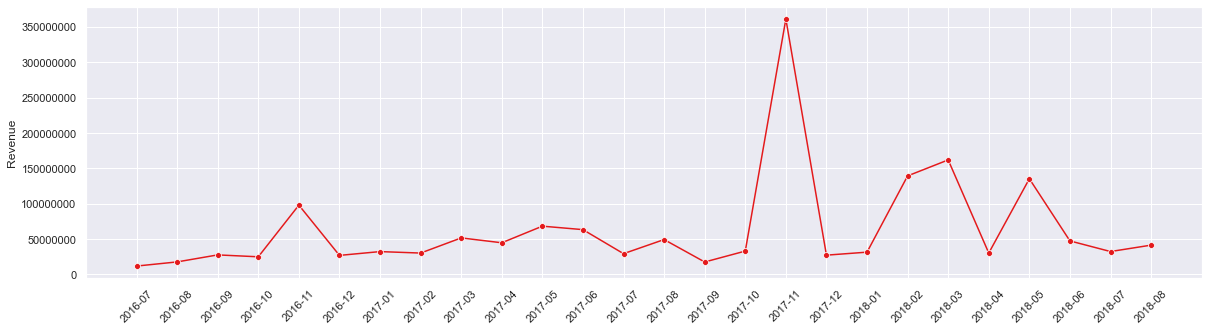

In [184]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.set(style="darkgrid", palette="Set1")
sns.lineplot(data=revenue, x="Year_Month", y="grand_total",marker="o")
ax.yaxis.get_major_formatter().set_scientific(False)
#ax.yaxis.get_major_formatter().set_useOffset(False)
ax.set_xlabel('')
ax.set_ylabel('Revenue')
plt.xticks(rotation=45);

In [185]:
created_at_y_m = dt["Year"].astype(str) + "-" + dt["Month"]
dt.insert(0,"Year_Month",created_at_y_m)

In [186]:
#2 統計每月份客單價 每月收入/訂單總數
orders = dt[dt["status"] == "completed"].groupby("Year_Month")["increment_id"].nunique().reset_index()
revenue["total_order"] = orders["increment_id"]
revenue["AOV"] = revenue["grand_total"]/revenue["total_order"]
revenue[["Year_Month","grand_total","total_order","AOV"]].head()

,Year_Month,grand_total,total_order,AOV
0,2016-07,11720820.27,4930,2377.45
1,2016-08,17588479.23,6467,2719.73
2,2016-09,27503668.06,7035,3909.55
3,2016-10,24824142.90,6304,3937.84
4,2016-11,97895239.77,30544,3205.06


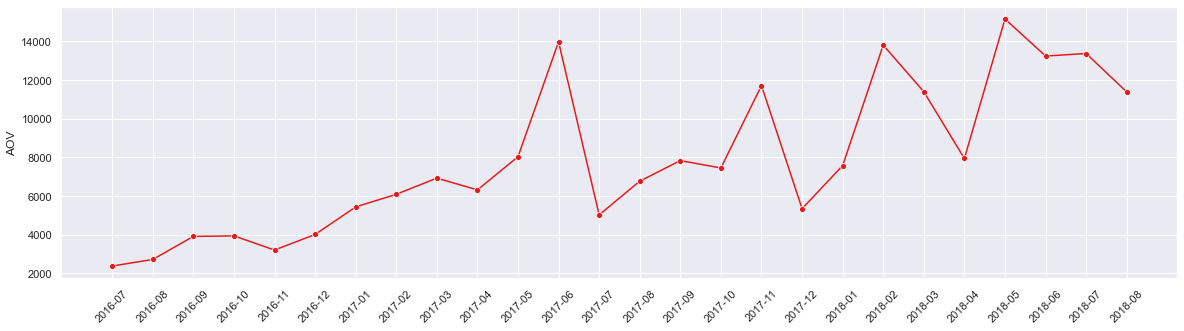

In [187]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.set(style="darkgrid", palette="YlGn")
sns.lineplot(data=revenue, x="Year_Month", y="AOV",marker="o")
ax.set_xlabel("")
ax.set_ylabel("AOV")
plt.xticks(rotation=45);

In [188]:
#3 統計每月份人均消費訂單數
customer_id_count = dt[dt["status"] == "completed"].groupby(["Year_Month"])["Customer ID"].nunique().reset_index()
customer_id_count["month_total_order"] = orders["increment_id"]
customer_id_count["month_capita_order"] = round(customer_id_count["month_total_order"]/customer_id_count["Customer ID"],2)
customer_id_count.head()

,Year_Month,Customer ID,month_total_order,month_capita_order
0,2016-07,1622,4930,3.04
1,2016-08,2640,6467,2.45
2,2016-09,3772,7035,1.87
3,2016-10,2765,6304,2.28
4,2016-11,12811,30544,2.38


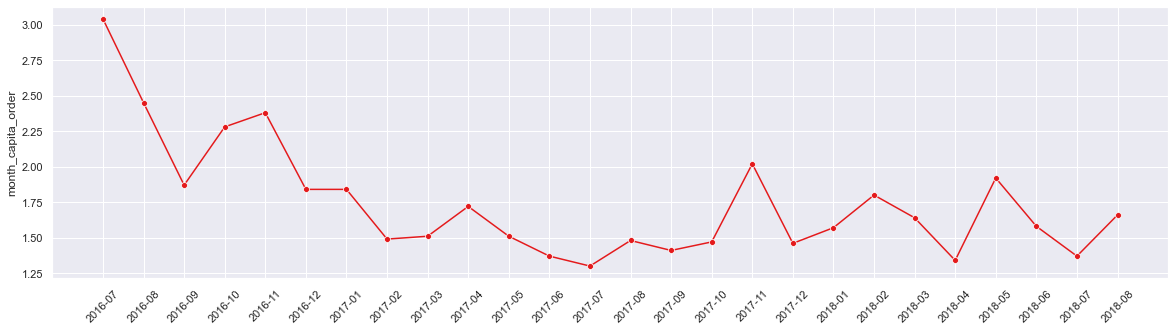

In [216]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.set(style="darkgrid", palette="bright")
sns.lineplot(data=customer_id_count, x="Year_Month", y="month_capita_order",marker="o")
ax.set_xlabel("")
ax.set_ylabel("month_capita_order")
plt.xticks(rotation=45);

In [190]:
#4 統計顧客訂單數比例(購買1次 vs 購買2次以上)
number_of_orders = dt[dt["status"] == "completed"].groupby("Customer ID")["increment_id"].nunique().reset_index()
one = len(number_of_orders[number_of_orders["increment_id"]==1])
more = len(number_of_orders[number_of_orders["increment_id"]!=1])
data = {"Order": ["One Order", "More than One Order"], "Customer_Counts": [one, more], "%":[one/(one+more),more/(one+more)]}
order_counts = pd.DataFrame.from_dict(data)
order_counts

,Order,Customer_Counts,%
0,One Order,51801,0.65
1,More than One Order,28320,0.35


In [191]:
#5 統計每月新舊客的人數和各自的營收貢獻 
# 新舊客定義為第一次購買為新客，若往後月份回購即列為舊客
iffirst_perchase = dt.groupby("Customer ID")["created_at_date"].agg("min").reset_index()
iffirst_perchase.columns = ["Customer ID","first_perchase"]
iffirst_perchase = iffirst_perchase.merge(dt,how="left")
iffirst_perchase = iffirst_perchase[iffirst_perchase["status"] == "completed"]
iffirst_perchase.head()

,Customer ID,first_perchase,Year_Month,item_id,status,created_at,sku,price,qty_ordered,grand_total,increment_id,category_name_1,discount_amount,payment_method,Year,Month,Day,created_at_date
0,1,2016-07-01,2016-07,211131.0,completed,2016-07-01,kreations_YI 06-L,1950.00,1,1950.00,100147443,Women's Fashion,0.00,cod,2016,07,01,2016-07-01
4,3,2016-07-01,2017-05,473369.0,completed,2017-05-19,BT_BT-422,530.00,1,1245.00,100306394,Men's Fashion,0.00,cod,2017,05,19,2017-05-19
5,3,2016-07-01,2017-05,473370.0,completed,2017-05-19,ALHAMRA_US-0961-K,299.00,1,1245.00,100306394,Men's Fashion,0.00,cod,2017,05,19,2017-05-19
6,3,2016-07-01,2017-05,473371.0,completed,2017-05-19,e-seller_7,66.00,1,1245.00,100306394,Mobiles & Tablets,0.00,cod,2017,05,19,2017-05-19
7,3,2016-07-01,2017-05,473372.0,completed,2017-05-19,BD_BIG DEAL_16,350.00,1,1245.00,100306394,Mobiles & Tablets,0.00,cod,2017,05,19,2017-05-19


In [192]:
#依照首購時間判斷是否為新舊客
def oldfriend(creat_d, first_d):
    if creat_d > first_d:
        return "return_customer"
    else:
        return "new_customer"

iffirst_perchase["new_return"] = iffirst_perchase.apply(lambda x: oldfriend(x["created_at_date"],x["first_perchase"]),axis=1)

In [193]:
iffirst_perchase.head(3)

,Customer ID,first_perchase,Year_Month,item_id,status,created_at,sku,price,qty_ordered,grand_total,increment_id,category_name_1,discount_amount,payment_method,Year,Month,Day,created_at_date,new_return
0,1,2016-07-01,2016-07,211131.0,completed,2016-07-01,kreations_YI 06-L,1950.00,1,1950.00,100147443,Women's Fashion,0.00,cod,2016,07,01,2016-07-01,new_customer
4,3,2016-07-01,2017-05,473369.0,completed,2017-05-19,BT_BT-422,530.00,1,1245.00,100306394,Men's Fashion,0.00,cod,2017,05,19,2017-05-19,return_customer
5,3,2016-07-01,2017-05,473370.0,completed,2017-05-19,ALHAMRA_US-0961-K,299.00,1,1245.00,100306394,Men's Fashion,0.00,cod,2017,05,19,2017-05-19,return_customer


In [194]:
new_return_G = iffirst_perchase.groupby(["Year_Month","new_return"])["grand_total"].agg(["sum","count"]).reset_index()
new_return_C = iffirst_perchase.groupby(["Year_Month","new_return"])["Customer ID"].nunique().reset_index()
# dt_temN = dt_temS[dt_temS["n_r"] == "new_customer"]
# dt_temR = dt_temS[dt_temS["n_r"] == "return_customer"]
new_return_T = new_return_C.merge(new_return_G,how="left")
new_return_T.head()

,Year_Month,new_return,Customer ID,sum,count
0,2016-07,new_customer,1496,7486043.52,2681
1,2016-07,return_customer,351,4234776.75,3242
2,2016-08,new_customer,2140,11524951.63,3073
3,2016-08,return_customer,726,6063527.60,4495
4,2016-09,new_customer,2959,17211146.60,3985


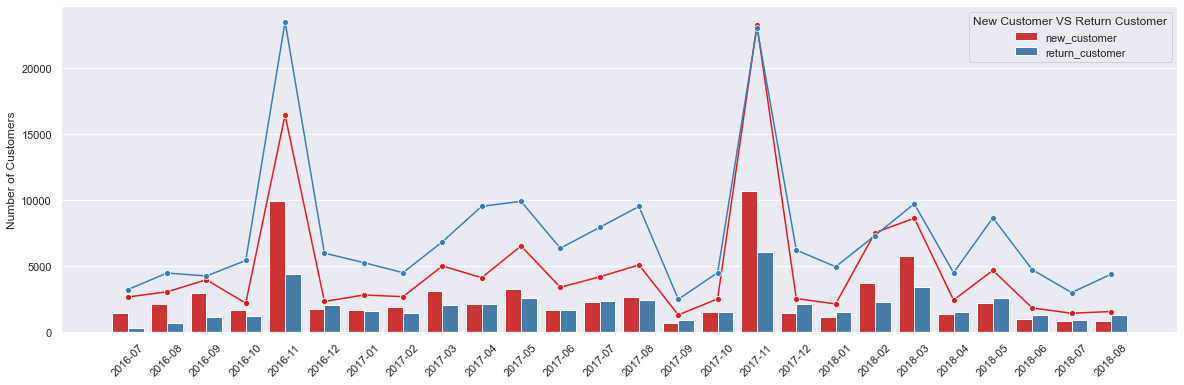

In [195]:
#每月新舊客人數圖表 & 訂單數
fig, ax = plt.subplots(figsize=(20, 6))
sns.set(style="darkgrid",palette="Set1")
sns.barplot(data=new_return_T, x="Year_Month", y="Customer ID", hue = "new_return")
sns.lineplot(data=new_return_T, x="Year_Month", y="count", hue = "new_return", marker= "o", legend= False)
ax.set_xlabel("")
ax.set_ylabel("Number of Customers")
# ax2 = ax.twinx()
# ax2.set_ylabel("Number of Orders")
ax.yaxis.get_major_formatter().set_scientific(False)
ax.xaxis.set_tick_params(rotation=45)
plt.legend(title="New Customer VS Return Customer");

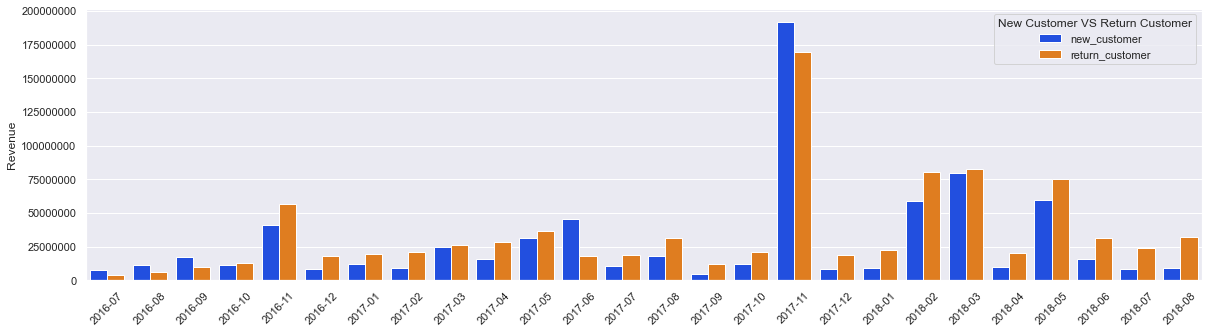

In [196]:
#每月新舊客消費金額圖表
fig, ax = plt.subplots(figsize=(20, 5))
sns.set(style="darkgrid",palette="bright")
sns.barplot(data=new_return_T, x="Year_Month", y="sum", hue = "new_return")
#sns.barplot(data=dt_temR, x="Year_Month", y="grand_total")
ax.set_xlabel("")
ax.set_ylabel("Revenue")
ax.yaxis.get_major_formatter().set_scientific(False)
ax.xaxis.set_tick_params(rotation=45)
plt.legend(title="New Customer VS Return Customer");

In [197]:
#6 計算每個月的回購率
purchase_time = dt[dt["status"] == "completed"].pivot_table(index="Customer ID",columns="Year_Month",values="increment_id",aggfunc="nunique",fill_value=0)
purchase_time.head()

Year_Month,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,...,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08
Customer ID,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,20,17,30,62,19,5,16,20,9,...,10,1,1,2,0,0,0,0,0,4
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0


In [198]:
pivot_purchase = purchase_time.applymap(lambda x:1 if x>0 else 0)
pivot_repurchase = (pivot_purchase.shift(-1,axis=1).fillna(0)+pivot_purchase).applymap(lambda x: 1 if x>1 else 0 )
pivot_repurchase = pivot_repurchase.shift(1,axis=1).fillna(0)
repurchase_rate = pivot_repurchase.sum()/pivot_purchase.sum()
repurchase_rate = repurchase_rate.reset_index(name = "repurchase_rate")

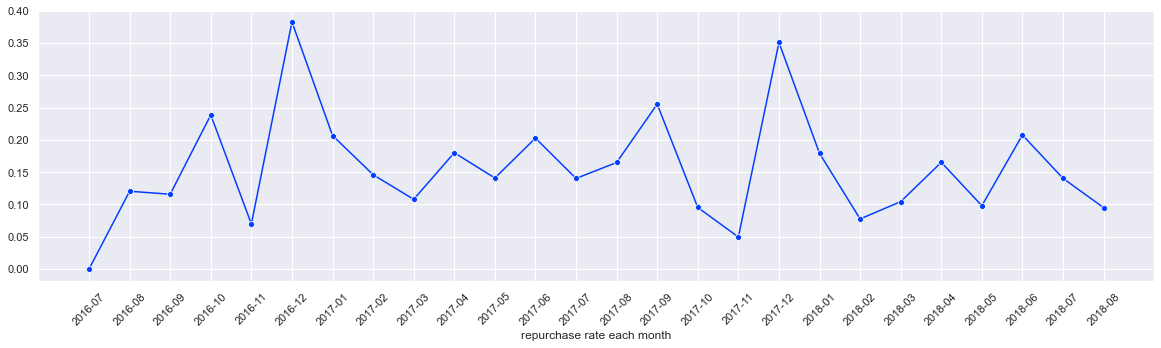

In [199]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.set(style="darkgrid", palette="Set1")
sns.lineplot(data=repurchase_rate, x="Year_Month", y="repurchase_rate",marker="o")
ax.set_xlabel("repurchase rate each month")
ax.set_ylabel("")
plt.xticks(rotation=45);

1.最近一次消費（Recency）。顧客上次消費時間愈近，價值愈大。

2.消費頻率（Frequency）。顧客在一個月或一年中，買了多少次東西？購買頻率愈高，用戶價值愈大。

3.消費金額（Monetary）。顧客一共在產品上花了多少錢？創造了多少利潤？消費金額愈高，用戶價值愈大。

In [200]:
#7 使用RFM模型將顧客分類成不同客群
#把 reference_date 設為顧客最後消費的3天後
reference_date = dt["created_at_date"].max() + timedelta(days=3)
print(f"Set the reference date as {reference_date}")

Set the reference date as 2018-08-31 00:00:00


In [201]:
rfm_dt = dt[dt["status"] == "completed"].groupby("Customer ID").agg \
    ({"created_at_date" : lambda created_at_date :(reference_date - created_at_date.max()).days,  # Recency
      "increment_id" : lambda increment_id: increment_id.nunique(),  # Frequency
      "grand_total":  lambda grand_total: grand_total.sum()}).reset_index().sort_values(by="Customer ID")    # Monetary

In [202]:
rfm_dt.head()

,Customer ID,created_at_date,increment_id,grand_total
0,1,791,1,1950.00
1,3,469,1,4980.00
2,4,4,236,1316173.25
3,6,791,1,170.00
4,7,503,4,105.00


In [203]:
#把欄位重新命名為 Recency, Frequency, Monetary
rfm_dt.columns = ["Customer ID", "Recency", "Frequency", "Monetary"]
rfm_dt.head()

,Customer ID,Recency,Frequency,Monetary
0,1,791,1,1950.00
1,3,469,1,4980.00
2,4,4,236,1316173.25
3,6,791,1,170.00
4,7,503,4,105.00


In [204]:
#R、F、M每一個維度劃分1~5分，5分代表最高分。
# Recency指標數字越小表示客戶近期剛購買，因此Recency越低則可得到更高分(5分)。
# Frequency和Monetary指標的表示客戶購買頻繁並且消費更多的金額，因此Frequency和Monetary值越高可得到更高分(5分)。
rfm_dt["Recency_Score"]  = pd.qcut(rfm_dt['Recency'], 5, [5, 4, 3, 2, 1])
rfm_dt["Frequency_Score"]  = pd.qcut(rfm_dt['Frequency'].rank(method="first"),  5, [1, 2, 3, 4, 5])
rfm_dt["Monetary_Score"]  = pd.qcut(rfm_dt['Monetary'], 5, [1, 2, 3, 4, 5])

In [205]:
rfm_dt["RFM_SCORE"] = (rfm_dt["Recency_Score"].astype(str) + rfm_dt["Frequency_Score"].astype(str) + rfm_dt["Monetary_Score"].astype(str))
rfm_dt.head()

,Customer ID,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_SCORE
0,1,791,1,1950.00,1,1,2,112
1,3,469,1,4980.00,2,1,3,213
2,4,4,236,1316173.25,5,5,5,555
3,6,791,1,170.00,1,1,1,111
4,7,503,4,105.00,2,5,1,251


在電商零售產業，若消費者每個月有固定搜尋和購買的習慣，那麼推測他會得到較高的 Recency_Score 和 Frequency_Score，這兩個分數比起 Monetary_Score 更為重要。  
因此，接下來我們使用 Recency_Score 和 Frequency_Score 來把顧客做分群。

<img width = "750" height ="410" src ="https://github.com/LiangYuDer/E-commerce-Analysis/blob/main/Recency%20and%20Frequency%20Grid.JPG?
raw=true"/>

In [206]:
#1. Champions VIP顧客
#2. Loyal Customers 忠實顧客
#3. Potential Loyalists 潛在的忠誠顧客
#4. New Customers 新顧客
#5. Promising 有希望的顧客
#6. Need Attention 需要關注的顧客
#7. About to Sleep 快睡著(流失)的顧客
#8. Can't Lose Them 不能失去的顧客
#9. At Risk 有風險的顧客
#10. Hibernating 冬眠(流失)的顧客

seg_map = {
    r"[1-2][1-2]": "Hibernating",
    r"[1-2][3-4]": "At Risk",
    r"[1-2]5": "Can't Lose Them",
    r"3[1-2]": "About To Sleep",
    r"33": "Need Attention",
    r"[3-4][4-5]": "Loyal Customers",
    r"41": "Promising",
    r"51": "New Customers",
    r"[4-5][2-3]": "Potential Loyalists",
    r"5[4-5]": "Champions"
}

In [207]:
rfm_dt["Segment"] = rfm_dt["Recency_Score"].astype(str) + rfm_dt["Frequency_Score"].astype(str)
rfm_dt["Segment"] = rfm_dt["Segment"].replace(seg_map, regex=True)
rfm_dt.head()

,Customer ID,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_SCORE,Segment
0,1,791,1,1950.00,1,1,2,112,Hibernating
1,3,469,1,4980.00,2,1,3,213,Hibernating
2,4,4,236,1316173.25,5,5,5,555,Champions
3,6,791,1,170.00,1,1,1,111,Hibernating
4,7,503,4,105.00,2,5,1,251,Can't Lose Them


In [208]:
#統計每個分組的顧客人數和比例
rfm_dt_segnum = rfm_dt.groupby("Segment").agg({"Customer ID":"count"}).sort_values("Customer ID", ascending=False).reset_index()
rfm_dt_segnum["%"] = 100 * (rfm_dt_segnum["Customer ID"] / rfm_dt_segnum["Customer ID"].sum())
rfm_dt_segnum.columns = ["Segment", "Customer Number","%"]
rfm_dt_segnum

,Segment,Customer Number,%
0,Hibernating,23565,29.41
1,Potential Loyalists,14508,18.11
2,Loyal Customers,12434,15.52
3,Champions,11146,13.91
4,About To Sleep,7931,9.90
5,At Risk,4653,5.81
6,Can't Lose Them,3815,4.76
7,Need Attention,1918,2.39
8,Promising,82,0.10
9,New Customers,69,0.09


In [209]:
#利用 treemap 呈現每個分組的顧客數量
colors=['#fae588','#f79d65','#f9dc5c','#e8ac65','#e76f51','#ef233c','#b7094c']
fig = px.treemap(rfm_dt_segnum, path=['Segment'],values='Customer Number', width=800, height=400)
fig.update_layout(
    treemapcolorway = colors, #defines the colors in the treemap
    margin = dict(t=10, l=20, r=20, b=10))
fig.show()

In [210]:
rfm_dt[["Segment","Recency", "Frequency", "Monetary"]].groupby("Segment").agg("mean")

,Recency,Frequency,Monetary
Segment,,,
About To Sleep,348.39,1.00,5620.94
At Risk,583.89,2.03,9968.36
Can't Lose Them,562.63,7.68,33207.72
Champions,86.20,5.57,54086.09
Hibernating,598.35,1.00,6757.04
Loyal Customers,277.38,4.66,41969.94
Need Attention,283.76,1.00,7732.71
New Customers,104.35,1.00,9837.70
Potential Loyalists,200.67,1.00,7881.36


In [217]:
#8 統計最有價值顧客購買的產品和消費總金額
rfm_dt_mapping = rfm_dt[["Customer ID","Segment"]]
dt_rfm = dt.merge(rfm_dt_mapping,how="left")
dt_rfm_champ =dt_rfm[(dt_rfm["status"] == "completed") & (dt_rfm["Segment"] == "Champions")].groupby("category_name_1")["grand_total"].agg(["count","sum"]).reset_index()
dt_rfm_champ

,category_name_1,count,sum
0,Appliances,9426,106733401.86
1,Beauty & Grooming,8470,16529698.62
2,Books,352,549723.02
3,Computing,2287,23105740.16
4,Entertainment,4502,81876816.60
5,Health & Sports,4963,9867515.07
6,Home & Living,5047,14345832.34
7,Kids & Baby,2695,7227147.44
8,Men's Fashion,11945,21257698.73
9,Mobiles & Tablets,15227,218141664.23


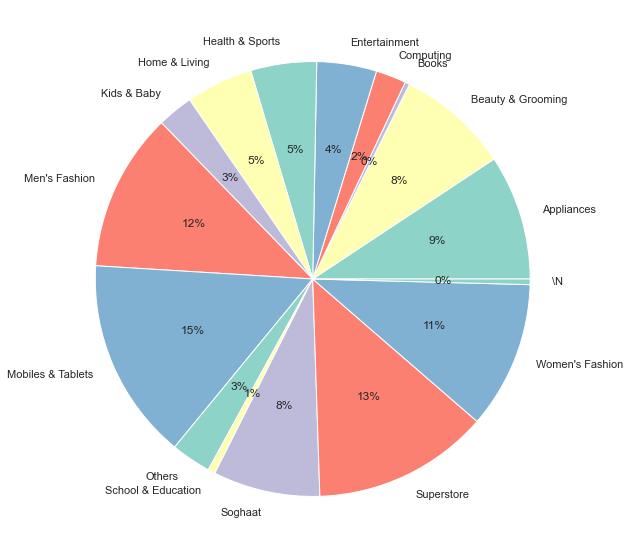

In [226]:
#8-1 最有價值顧客購買的商品圓餅圖
fig, ax = plt.subplots(figsize=(10, 10))
colors = sns.color_palette("Set3")[0:5]
plt.pie(dt_rfm_champ["count"], labels = dt_rfm_champ["category_name_1"], colors=colors, autopct='%.0f%%')
plt.show()

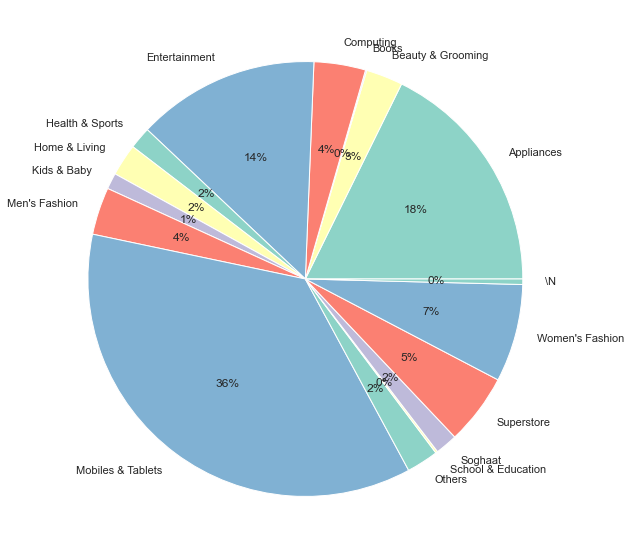

In [229]:
#8-2 最有價值顧客購買商品的消費總金額圓餅圖
fig, ax = plt.subplots(figsize=(10, 10))
colors = sns.color_palette("Set3")[0:5]
plt.pie(dt_rfm_champ["sum"], labels = dt_rfm_champ["category_name_1"], colors=colors, autopct='%.0f%%')
plt.show()

In [212]:
# shop_sum = revenue.groupby("invoice_date_y")["price"].agg("sum")
# customer_id_count = df.groupby("invoice_date_y")["invoice_no","customer_id"].nunique()
# customer_id_count
# shop_per_num =pd.concat([shop_sum,customer_id_count],axis=1)
# shop_per_num

In [213]:
#order_data = pd.merge(df_orders, df_order_payments, on="order_id")
# order_count = order_data[order_data["order_status"] != "canceled"].groupby("order_purchase_y").agg("count")
# customer_id_count = order_data[order_data["order_status"] != "canceled"].groupby("order_purchase_y")["customer_id"].nunique()
# order_count

)

In [214]:
#2016 - 2018 人均訂單數
# customer_id
# order_count = order_data[order_data["order_status"] != "canceled"].groupby("order_purchase_y").agg("count")
# customer_id_count = order_data[order_data["order_status"] != "canceled"].groupby("order_purchase_y")["customer_id"].nunique()
# order_count


In [215]:
# customer_id_count


# grand_total_check = dt[dt["grand_total"] < 0]["status"].value_counts().rename_axis("status").reset_index(name="counts")
# #grand_total_check
# fig, ax = plt.subplots(figsize=(15,5))
# sns.set(style="darkgrid", palette="bright")
# g = sns.barplot(data=grand_total_check, x="status", y="counts")
# ax.bar_label(g.containers[0], padding = 0, fontsize = 12)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.xlabel('Order Status', fontsize=12, labelpad=10)
# plt.ylabel('Counts', fontsize=12, labelpad=10)